# 4ab Creating a Multigrid Poisson Solver
Multigrid solvers are built on a few key observations:
  * Iterative solvers, like the Jacobi solver, correct the small scale errors of a solution faster than the large scale errors
  * The solution to the Poisson equation can be used to formulate an analogous equation for the solution of the error term
  * By using a __restriction operator__ we can solve the equation for the error term on a coarse mesh
  * By using a __prolongation operator__ we can propogate the solution for the error term from the coarse to the fine mesh
  * This can be done recursively
  * Solving on the coarse mesh is cheaper by a factor 2^ndim

In this exercise you will get the chance to build a nice recursive piece of code by yourself and create a multigrid solver. Below are only given the logical pieces, the rest you have to create.

_This exercise counts for the full week_

## Preparation:
At the bottom write a section heading, "Solution", and copy the multigrid class and the small piece of to run the solver below it. This gives you a clean reference code above, and makes it easier to see what has been modified.

#### Task 1 (40 pt):  
Create the prolongation and restriction operators, and the central recursive algorithm (see the code below).

#### Task 2 (40 pt):
Validate the solver. Multigrid solvers have the central property that, for a given tolerance, the number of needed multigrid cycles only depends weakly on the resolution.
Compare with a simple Jacobi integrator. Notice the ```maxit```option that may have to be increased for it to converge, if you go to high resolutions.

#### Task 3 (20 pt):
Timing: at what resolution does your multigrid solver become faster than the Jacobi solver?

#### Extra open task  (up to 20 pt):
The convergence properties of a multi grid solver can be be improved by not doing the full cycle up and down (V-cycle), but instead first going all the way down, then half way up, down again, and then all the way up (W-cycle), and this can be done recursively -- like a W inside a W inside a W inside ... Change the solver to a W-cycle, or explore other cycle configurations (see e.g. the link at the end of the slides). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
np.set_printoptions(linewidth = 120)

### Small function for showing images of 2D arrays

In [2]:
def imshow(f,title='',**kwargs):
    """ Show an image, with preferred orientation """
    plt.imshow(np.transpose(f),origin='lower',**kwargs)
    plt.colorbar()
    plt.title('{}  max:{:.4f}  min:{:.4f}'.format(title,f.max(),f.min()));

def imshows(f, title='', **kwargs):
    f=np.array(f)
    if f.ndim==2:
        imshow(f,title,**kwargs)
    else:
        n=f.shape[0]
        rows=1+(n-1)//3
        cols=min(n,3)
        plt.figure(figsize=(cols*5,rows*4))
        for i in range(n):
            plt.subplot(rows,cols,1+i)
            if type(title) is np.ndarray:
                t=title[i]
            else:
                t=title
            imshow(f[i,:,:],t,**kwargs);

### Class for initial conditions

In [3]:
class BonnorEbert():
    """ Simple 1/(r+rc)^2 for r < r0 density distribution """
    def __init__(self, n = None, G = 1, size = 2, center = 0, r0 = 0.5, rc = 0.1):
        assert type(n)!=int, "This code is designed for 3D problems. n needs 3 elements"
        assert len(n)==3,    "This code is designed for 3D problems. n needs 3 elements"
        self.n = n                                      # Number of grid points
        self.ds = np.array(size) / n                    # Cell size
        self.size = self.ds * n                         # Domain size

        # make cell centered coordinates with domain centered on "center"
        self.lb = center - 0.5*self.size    # Lower bound of the domain
        self.ub = center + 0.5*self.size    # Upper bound of the domain
        self.axis = []
        for i in range(3):
            self.axis.append(np.linspace(self.lb[i],self.ub[i],self.n[i], endpoint=False) + 0.5 * self.ds[i])
        self.coords = np.meshgrid(*self.axis,indexing='ij',sparse=True) # expand to 3D grid

        self.x = self.axis[0]
        self.y = self.axis[1]
        self.z = self.axis[2]
        self.r = np.sqrt(self.coords[0]**2 + self.coords[1]**2 + self.coords[2]**2)     # Spherical radius
        self.G    = G                                                                   # Newtons constant of gravity
        self.D = np.zeros(self.n)                                                       # Density
        mask = self.r <= r0
        self.D[mask] = 1. / (self.r[mask]+rc)**2                                        # Create a central density blob

### Jacobi solver and computation of residual

In [4]:
def Jacobi_residual(Phi, S):
    """ Calculate explicit residual for given Phi, S """
    n = Phi.shape        # Grid size
    res = np.copy(S)
    for i in range(3):
        if n[i] > 1:
            res += (np.roll(Phi, +1, axis = i) + np.roll(Phi, -1, axis = i)) - 2.*Phi
    # Fix boundaries
    if n[0] > 2:
        res[0,:,:] = res[-1,:,:] = 0.
    if n[1] > 2:
        res[:,0,:] = res[:,-1,:] = 0.
    if n[2] > 2:
        res[:,:,0] = res[:,:,-1] = 0.
    return res

def Jacobi(Phi, S):
    """ Jacobi iteration for multi-grid self-gravity."""
    n = Phi.shape                       # Grid size

    const = 0.                          # Prefactor for normalising dimensions (2 * ndim)
    #   phi = 1/(2ndim) (phi(i-1,j,k)+phi(i+1,j,k)+... - 4 pi G ds^2 rho)
    #   Pad Phi with zeros in each direction for boundary values (assumed to be zero) using numpy.pad
    Phi_new = np.copy(S)                # Copy source
    if n[0] > 1:
        const += 2.
        PP = np.pad(Phi, ((1,1),(0,0),(0,0)), 'constant', constant_values=(0., 0.))         # np.pad adds a layer of zeros around the array (boundary conditions)
        Phi_new += (np.roll(PP, +1, axis = 0) + np.roll(PP, -1, axis = 0))[1:-1,:,:]
    if n[1] > 1:
        const += 2.
        PP = np.pad(Phi, ((0,0),(1,1),(0,0)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP, +1, axis = 1) + np.roll(PP, -1, axis = 1))[:,1:-1,:]
    if n[2] > 1:
        const += 2.
        PP = np.pad(Phi, ((0,0),(0,0),(1,1)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP, +1, axis = 2) + np.roll(PP, -1, axis = 2))[:,:,1:-1]

    Phi_new *= (1./const)                # Normalise

    # Return solution (updated potential) and residual (Phi_new - Phi = S + Laplace Phi)
    return Phi_new, Phi_new - Phi

### Iterative Jacobi solver for selfgravity

In [5]:
class poisson():
    def __init__(self, u, tolerance = 1e-4, maxit = 2000):
        """ Initialize a Poisson solver """
        self.n         = u.n       # Mesh size
        self.maxit     = maxit     # Maximum number of iterative steps to take
        self.tolerance = tolerance # Tolerance to satisfy for the error

    # Iterative Solver for the Poisson Problem
    def Poisson(self,u):
        assert ((u.ds[0] == u.ds[1]) and (u.ds[1] == u.ds[2])), "Cell size must be equal in all dimensions"
        S = -(4.*np.pi*u.G)*u.D*u.ds[0]**2
        norm   = np.amax(np.abs(S))                 # Something we can compare the error (residual) to
        Phi = np.zeros(self.n)                      # Start guess = 0
        self.it = 0; self.error = self.tolerance
        while self.error >= self.tolerance and self.it < self.maxit:
            Phi, residual = Jacobi(Phi, S)
            self.error = np.amax(np.abs(residual) / norm)
            self.it+=1
            
        residual = Jacobi_residual(Phi, S)
                    
        return Phi, self.it, self.error, residual

### Driver for calling the Jacobi solver

In [200]:
experiment = BonnorEbert(n = (128, 128, 128), rc = 0.1, r0 = 0.5)
solver = poisson(experiment, maxit = 8000, tolerance = 1e-4)

start = time()
Phi, nt, err, res = solver.Poisson(experiment)
used = time() - start
ntot = np.prod(experiment.n)
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(nt, err, solver.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(used,1e6*used/ntot,1e9*used/(ntot*nt)))

# Show solution, Phi, and residual, res, side-by-side
imshows(np.array( [Phi[:,:,experiment.n[2]//2],res[:,:,experiment.n[2]//2]]))

KeyboardInterrupt: 

### Investigating the solution

Plot the size of the potential, $\Phi$, as a function of distance from center $r$. Notice how it strays from a perfect spherical solution because we restrict it to be zero on the boundary

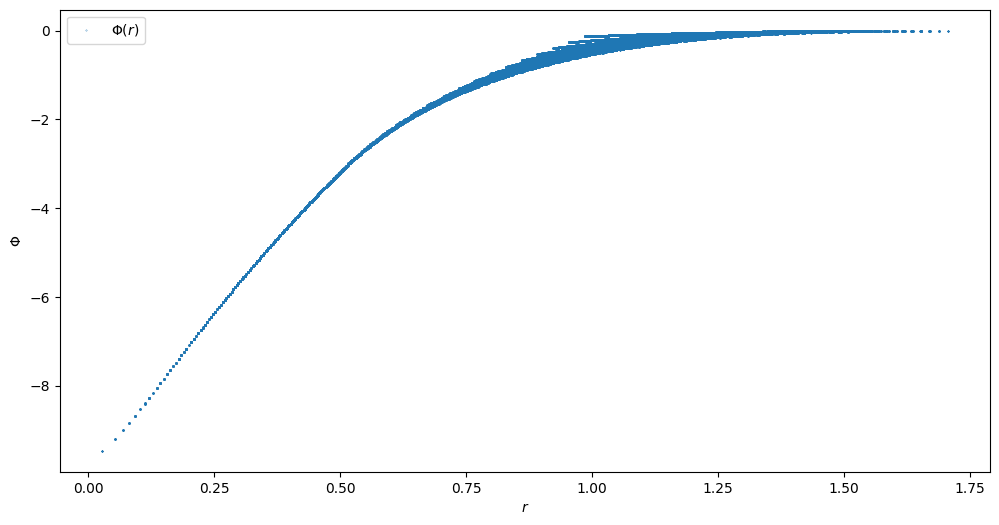

In [15]:
f = plt.figure(figsize = (12, 6))
plt.plot(experiment.r.ravel(), Phi.ravel(), '.', markersize = 0.5, label = r'$\Phi(r)$')
plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi$')
plt.legend();

### Multigrid Solver

Make a Multigrid solver class / object, which given a hydro object finds the solution for the potential

In [8]:
class Multigrid():
    def __init__(self, tolerance = 1e-5, maxit = 1000):
        """ Initialize Poisson solver class """
        self.maxit = maxit                  # Maximum number multigrid iterations. Depends on tolerance
        self.tolerance = tolerance          # Tolerance to satisfy for the error
        self.first_time = [True]*20         # Flag to print info on each level only once. Works up to resolution of 2**20

    def print_info(self, level, n):
        """ Print info about current level and grid size """
        if self.first_time[level]:
            print ("MG level = {} n = {}".format(level, n))
            self.first_time[level] = False

    def can_restrict(self,n):
        """ Test if we can divide any resolution by 2 """
        for i in range(len(n)):
            if n[i] > 2 and n[i] % 2 == 0:
                return True

    def restrict(self, f_fine):
        """ Restrict residual to coarser level by taking every second element """
        n = np.array(np.shape(f_fine))
        # calculate f_coarse and return it
        # ...

    def prolong(self, f_coarse):
        """ Prolong solution to finer level by copy for every second point and average for every second point """
        # calculate f_fine and return it
        # ...

    # The heart of the multigrid algorithm. This function should call itself recursively.
    # As given, it just updates Phi and does two times itsmooth Jacobi iterations
    def Vcycle(self, Phi, source, level):
        Phi[:,:,:], _ = Jacobi(Phi, source)             # Improve solution at grid-scale
        residual = Jacobi_residual(Phi, source)

        n = Phi.shape
        self.print_info(level, n)                       # Print some info first time this level is visited
        if self.can_restrict(n):                        # If not on coarsest level, recurse
            ...
            # 1. restrict *residual* from current to coarse level
            # 2. call solve at coarser level (e.g. level+1)
            # 3. prolong the solution for Phi from the coarser level (=level+1) and add to solution on this level

        Phi[:,:,:], _ = Jacobi(Phi, source) # improve solution at grid-scale
        return Phi

    def full_solve(self, Phi, source):
        norm   = np.amax(np.abs(S))                  # Normalisation for residual
        self.it = 0
        self.error = self.tolerance
        # Main loop
        while self.error >= self.tolerance and self.it<self.maxit:
            Phi = self.Vcycle(Phi, source, 0)           # Do a full V-shaped multigrid cycle
            self.it += 1                                # Inc nr of MG iterations
            res = Jacobi_residual(Phi, source)          # Compute residual
            self.error = np.amax(np.abs(res) / norm)    # Estimate error
            
        return Phi, res

MG level = 0 n = (32, 32, 32)
Nr of iterations, error, tolerance : 693 9.97e-05 1.0e-04
Time = 0.6 seconds, 17.2 musec/cell, 17.4 nanosec/cell/it


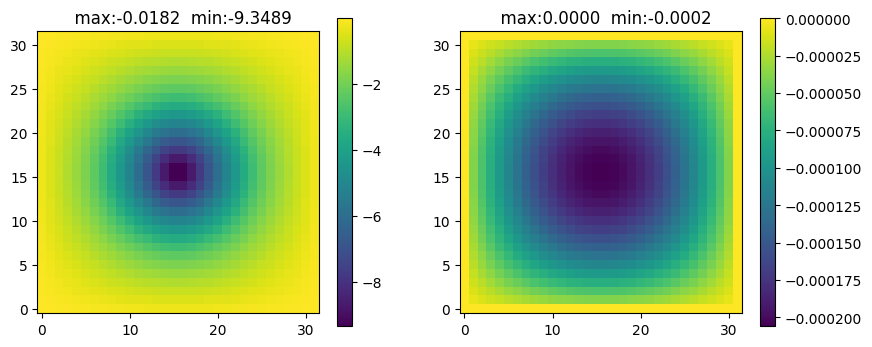

In [9]:
n = (32, 32, 32)
experiment = BonnorEbert(n = n, rc = 0.1, r0 = 0.5)                 # Compute the density distribution
M = Multigrid(maxit = 5000, tolerance = 1e-4)                       # Setup the Multigrid solver object

start = time()                                                      # For timing

Phi = np.zeros(experiment.n)                                        # Initial guess for Phi
S = -(4.*np.pi*experiment.G)*experiment.D*experiment.ds[0]**2       # Source term
Phi, res = M.full_solve(Phi, S)                                     # Call the multigrid solver
used = time() - start                                               # For timing

# Print some statistics
ntot = np.prod(experiment.n)
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(used, 1e6*used/ntot, 1e9*used/(ntot*nt)))

# Show potetial and residual
imshows(np.array( [Phi[:,:,experiment.n[2]//2],res[:,:,experiment.n[2]//2]]))

----
#### Add your solution below

#### Task 1 + extra task (implementing W-cycle)

In [224]:
class Multigrid():
    def __init__(self, tolerance = 1e-5, maxit = 1000):
        """ Initialize Poisson solver class """
        self.maxit = maxit                  # Maximum number multigrid iterations. Depends on tolerance
        self.tolerance = tolerance          # Tolerance to satisfy for the error
        self.first_time = [True]*20         # Flag to print info on each level only once. Works up to resolution of 2**20

    def print_info(self, level, n):
        """ Print info about current level and grid size """
        if self.first_time[level]:
            print ("MG level = {} n = {}".format(level, n))
            self.first_time[level] = False

    def can_restrict(self, n):
        """ Test if we can divide any resolution by 2 """
        for i in range(len(n)):
            if n[i] > 2 and n[i] % 2 == 0:
                return True

    def restrict(self, f_fine):
        """ Restrict residual to coarser level by taking every second element """
        n = np.array(np.shape(f_fine))
        # Calculating f_coarse as every second element of f_fine since we are restricting the grid size by 2 in each dimension to get to the next level (coarser level)
        f_coarse = f_fine[::2, ::2, ::2]

        # Print the shape of the coarse grid to check if it is correct
        #print('Shape of coarse grid:', f_coarse.shape)

        return f_coarse

    def prolong(self, f_coarse):
        """ Prolong solution to finer level """
        n = np.array(np.shape(f_coarse))
        f_coarse_rolled = np.roll(f_coarse, 1, axis=0)
        #print(f"Shape of f_coarse after roll: {f_coarse_rolled.shape}")
        # Create an empty finer grid with double the resolution
        f_fine = np.zeros((2 * n[0], 2 * n[1], 2 * n[2]))  # Double the resolution

        # Assign coarse grid values to every second point in the finer grid
        f_fine[::2, ::2, ::2] = f_coarse                                                 # Even indices along all axes

        # Interpolation for odd indices along each axis
        f_fine[1::2, ::2, ::2] = 0.5 * (f_coarse + np.roll(f_coarse, -1, axis = 0))  # x-axis
        f_fine[::2, 1::2, ::2] = 0.5 * (f_coarse + np.roll(f_coarse, -1, axis = 1))  # y-axis
        f_fine[::2, ::2, 1::2] = 0.5 * (f_coarse + np.roll(f_coarse, -1, axis = 2))  # z-axis

        # Interpolate along pairs of axes
        f_fine[1::2, 1::2, ::2] = 0.25 * (f_coarse + np.roll(f_coarse, -1, axis = 0) + np.roll(f_coarse, -1, axis = 1) + np.roll(np.roll(f_coarse, -1, axis = 0), -1, axis = 1))        # x-y plane
        f_fine[1::2, ::2, 1::2] = 0.25 * (f_coarse + np.roll(f_coarse, -1, axis = 0) + np.roll(f_coarse, -1, axis = 2) + np.roll(np.roll(f_coarse, -1, axis = 0), -1, axis = 2))        # x-z plane
        f_fine[::2, 1::2, 1::2] = 0.25 * (f_coarse + np.roll(f_coarse, -1, axis = 1) + np.roll(f_coarse, -1, axis = 2) + np.roll(np.roll(f_coarse, -1, axis = 1), -1, axis = 2))        # y-z plane

        # Fully interpolate the center points
        f_fine[1::2, 1::2, 1::2] = 0.125 * (f_coarse + 
                                            np.roll(f_coarse, -1, axis = 0) + np.roll(f_coarse, -1, axis = 1) + np.roll(f_coarse, -1, axis = 2) 
                                            + np.roll(np.roll(f_coarse, -1, axis = 0), -1, axis = 1) + np.roll(np.roll(f_coarse, -1, axis = 0), -1, axis = 2) + np.roll(np.roll(f_coarse, -1, axis = 1), -1, axis = 2)
                                            + np.roll(np.roll(np.roll(f_coarse, -1, axis = 0), -1, axis = 1), -1, axis = 2))        # x-y-z cube
 
        # Print the shape of the fine grid to check if it is correct
        #print("Shape of f_fine before return:", f_fine.shape)

        return f_fine

    # The heart of the multigrid algorithm. This function should call itself recursively.
    # As given, it just updates Phi and does two times itsmooth Jacobi iterations
    def Vcycle(self, Phi, source, level):
        Phi[:,:,:], _ = Jacobi(Phi, source)             # Guess for Phi
        residual = Jacobi_residual(Phi, source)

        n = Phi.shape
        #print('Phi shape:', n)
        self.print_info(level, n)                       # Print some info first time this level is visited
        if self.can_restrict(n):                        # If not on coarsest level, recurse
            # First we restrict the residual from current to coarser level
            res_coarse = self.restrict(residual)

            # Then we call the solve function at coarser level (e.g., level+1)
            Phi_coarse = np.zeros_like(res_coarse)
            Phi_coarse = self.Vcycle(Phi_coarse, res_coarse, level+1)
            #print('Phi_coarse shape:', Phi_coarse.shape)

            # Finally, we prolong the solution for Phi from the coarser level (=level+1) and add to solution on this level
            Phi += self.prolong(Phi_coarse)

        Phi[:,:,:], _ = Jacobi(Phi, source) # Improve solution at grid-scale
        return Phi
    
    def Wcycle(self, Phi, source, level, llst):
        llst.append(level)
        Phi[:,:,:], _ = Jacobi(Phi, source)             # Guess for Phi
        residual = Jacobi_residual(Phi, source)

        n = Phi.shape
        self.print_info(level, n)                       # Print some info first time this level is visited

        if self.can_restrict(n):                        # If not on coarsest level, recurse
            
            # First we restrict the residual from current to coarser level 
            res_coarse = self.restrict(residual)
            Phi_coarse = np.zeros_like(res_coarse)
            Phi_coarse = self.Wcycle(Phi_coarse, res_coarse, level + 1, llst)
            Phi += self.prolong(Phi_coarse)
            llst.append(level)

            Phi[:,:,:], _ = Jacobi(Phi, source) 
            residual = Jacobi_residual(Phi, source)

            res_coarse = self.restrict(residual)
            Phi_coarse = np.zeros_like(res_coarse)
            Phi_coarse = self.Wcycle(Phi_coarse, res_coarse, level + 1, llst)
            Phi += self.prolong(Phi_coarse)
            llst.append(level)


        Phi[:,:,:], _ = Jacobi(Phi, source) 
        return Phi

    def full_solve(self, Phi, source, levels = None, W_cycle = False):
        norm   = np.amax(np.abs(S))                  # Normalisation for residual
        self.it = 0
        self.error = self.tolerance
        # Main loop
        while self.error >= self.tolerance and self.it<self.maxit:
            if W_cycle == True:
                Phi = self.Wcycle(Phi, source, 0, llst = levels)                   # Do a full W-shaped multigrid cycle if W_cycle is True
            else:
                Phi = self.Vcycle(Phi, source, 0)                   # Do a full V-shaped multigrid cycle
            self.it += 1                                            # Inc nr of MG iterations
            res = Jacobi_residual(Phi, source)                      # Compute residual
            self.error = np.amax(np.abs(res) / norm)                # Estimate error
            
        return Phi, res

#### Task 2

#### Testing the V-cycle

MG level = 0 n = (128, 128, 128)
MG level = 1 n = (64, 64, 64)
MG level = 2 n = (32, 32, 32)
MG level = 3 n = (16, 16, 16)
MG level = 4 n = (8, 8, 8)
MG level = 5 n = (4, 4, 4)
MG level = 6 n = (2, 2, 2)
Nr of iterations, error, tolerance : 1722 9.99e-05 1.0e-04
Time = 108.1 seconds, 51.5 musec/cell, 29.9 nanosec/cell/it


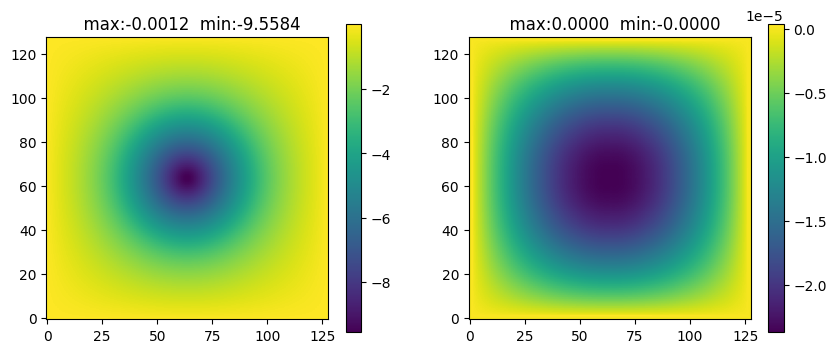

In [167]:
# Testing the Multigrid class
n = (128, 128, 128)
experiment = BonnorEbert(n = n, rc = 0.1, r0 = 0.5)                 # Compute the density distribution
M = Multigrid(maxit = 5000, tolerance = 1e-4)                       # Setup the Multigrid solver object

start = time()                                                      # For timing

Phi = np.zeros(experiment.n)                                        # Initial guess for Phi
S = -(4.*np.pi*experiment.G)*experiment.D*experiment.ds[0]**2       # Source term
Phi, res = M.full_solve(Phi, S)                                     # Call the multigrid solver
used = time() - start                                               # For timing

# Print some statistics
ntot = np.prod(experiment.n)
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(used, 1e6*used/ntot, 1e9*used/(ntot*M.it)))

# Show potetial and residual
imshows(np.array( [Phi[:,:,experiment.n[2]//2],res[:,:,experiment.n[2]//2]]))

##### Testing the W-cycle

MG level = 0 n = (128, 128, 128)
MG level = 1 n = (64, 64, 64)
MG level = 2 n = (32, 32, 32)
MG level = 3 n = (16, 16, 16)
MG level = 4 n = (8, 8, 8)
MG level = 5 n = (4, 4, 4)
MG level = 6 n = (2, 2, 2)
Nr of iterations, error, tolerance : 162 9.75e-05 1.0e-04
Time = 25.6 seconds, 12.2 musec/cell, 75.2 nanosec/cell/it


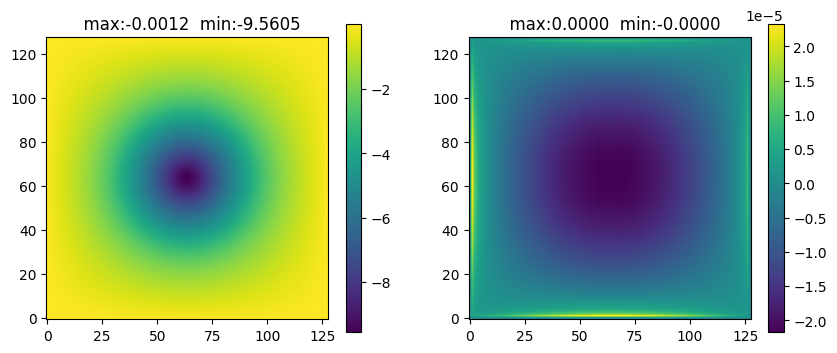

In [225]:
# Testing the Multigrid class (the W-cycle)
n = (128, 128, 128)
experiment = BonnorEbert(n = n, rc = 0.1, r0 = 0.5)                 # Compute the density distribution
M = Multigrid(maxit = 5000, tolerance = 1e-4)                       # Setup the Multigrid solver object

start = time()                                                      # For timing

levels = []

Phi = np.zeros(experiment.n)                                        # Initial guess for Phi
S = -(4.*np.pi*experiment.G)*experiment.D*experiment.ds[0]**2       # Source term
Phi, res = M.full_solve(Phi, S, levels, W_cycle = True)                                     # Call the multigrid solver
used = time() - start                                               # For timing

# Print some statistics
ntot = np.prod(experiment.n)
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(used, 1e6*used/ntot, 1e9*used/(ntot*M.it)))

# Show potetial and residual
imshows(np.array( [Phi[:,:,experiment.n[2]//2],res[:,:,experiment.n[2]//2]]))

Text(0.5, 1.0, 'Level history of one full W-cycle')

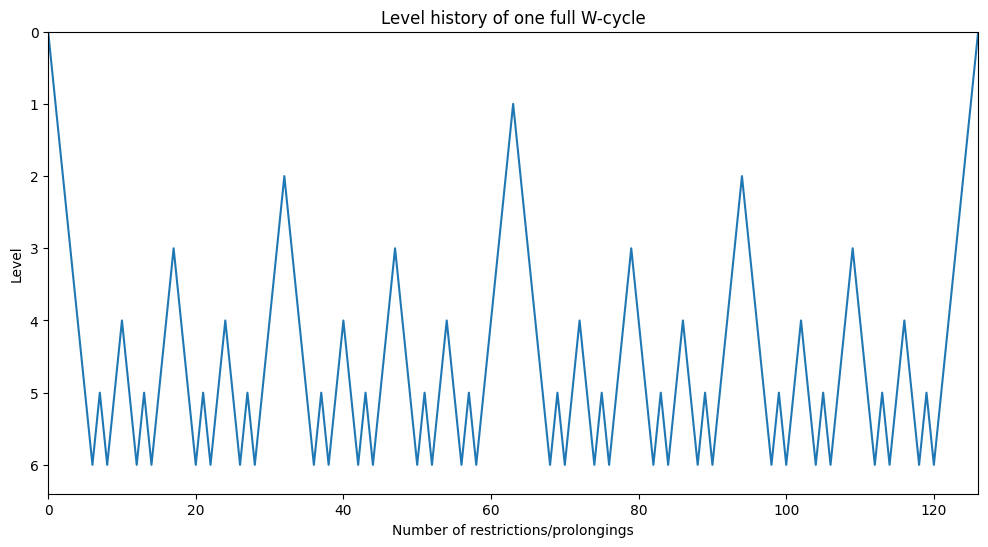

In [243]:
# Plotting the levels
plt.figure(figsize = (12, 6))
plt.plot(levels)
plt.xlim(0, 126)
plt.ylim(6.4, 0)
plt.ylabel('Level')
plt.xlabel('Number of restrictions/prolongings')
plt.title('Level history of one full W-cycle')


### Task 3

In [209]:
# Comparing the Multigrid solver to the Poisson solver (Jacobi iteration)
N = [16, 32, 64, 128]

time_P = []
time_M_Vcycle = []

for i in range(len(N)): 
    n = (N[i], N[i], N[i])
    experiment = BonnorEbert(n = n, rc = 0.1, r0 = 0.5)                 # Compute the density distribution
    solver = poisson(experiment, maxit = 12000, tolerance = 1e-4)        # Setup the Poisson solver object

    start_P = time()                                                        # For timing
    Phi_P, nt_P, err_P, res_P = solver.Poisson(experiment)                  # Call the Poisson solver
    used_P = time() - start_P                                               # For timing
    ntot_P = np.prod(experiment.n)

    time_P.append(used_P)

for i in range(len(N)):
    n = (N[i], N[i], N[i])
    experiment = BonnorEbert(n = n, rc = 0.1, r0 = 0.5)                         # Compute the density distribution
    M = Multigrid(maxit = 5000, tolerance = 1e-4)                               # Setup the Multigrid solver object

    start_M_V = time()                                                          # For timing
    Phi_M_V = np.zeros(experiment.n)                                            # Initial guess for Phi
    S_M_V = -(4.*np.pi*experiment.G)*experiment.D*experiment.ds[0]**2           # Source term
    Phi_M_V, res_M_V = M.full_solve(Phi_M_V, S_M_V)                             # Call the multigrid solver
    used_M_Vcycle = time() - start_M_V                                          # For timing
    ntot_M_V = np.prod(experiment.n)

    time_M_Vcycle.append(used_M_Vcycle)

MG level = 0 n = (16, 16, 16)
MG level = 1 n = (8, 8, 8)
MG level = 2 n = (4, 4, 4)
MG level = 3 n = (2, 2, 2)
MG level = 0 n = (32, 32, 32)
MG level = 1 n = (16, 16, 16)
MG level = 2 n = (8, 8, 8)
MG level = 3 n = (4, 4, 4)
MG level = 4 n = (2, 2, 2)
MG level = 0 n = (64, 64, 64)
MG level = 1 n = (32, 32, 32)
MG level = 2 n = (16, 16, 16)
MG level = 3 n = (8, 8, 8)
MG level = 4 n = (4, 4, 4)
MG level = 5 n = (2, 2, 2)
MG level = 0 n = (128, 128, 128)
MG level = 1 n = (64, 64, 64)
MG level = 2 n = (32, 32, 32)
MG level = 3 n = (16, 16, 16)
MG level = 4 n = (8, 8, 8)
MG level = 5 n = (4, 4, 4)
MG level = 6 n = (2, 2, 2)


In [245]:
time_M_Wcycle = []
levels = []

for i in range(len(N)):
    n = (N[i], N[i], N[i])
    experiment = BonnorEbert(n = n, rc = 0.1, r0 = 0.5)                                 # Compute the density distribution
    M = Multigrid(maxit = 5000, tolerance = 1e-4)                                       # Setup the Multigrid solver object

    start_M_W = time()                                                                  # For timing
    Phi_M_W = np.zeros(experiment.n)                                                    # Initial guess for Phi
    S_M_W = -(4.*np.pi*experiment.G)*experiment.D*experiment.ds[0]**2                   # Source term
    Phi_M_W, res_M_W = M.full_solve(Phi_M_W, S_M_W, levels, W_cycle = True)                     # Call the multigrid solver
    used_M_Wcycle = time() - start_M_W                                                  # For timing
    ntot_M_W = np.prod(experiment.n)

    time_M_Wcycle.append(used_M_Wcycle)

MG level = 0 n = (16, 16, 16)
MG level = 1 n = (8, 8, 8)
MG level = 2 n = (4, 4, 4)
MG level = 3 n = (2, 2, 2)
MG level = 0 n = (32, 32, 32)
MG level = 1 n = (16, 16, 16)
MG level = 2 n = (8, 8, 8)
MG level = 3 n = (4, 4, 4)
MG level = 4 n = (2, 2, 2)
MG level = 0 n = (64, 64, 64)
MG level = 1 n = (32, 32, 32)
MG level = 2 n = (16, 16, 16)
MG level = 3 n = (8, 8, 8)
MG level = 4 n = (4, 4, 4)
MG level = 5 n = (2, 2, 2)
MG level = 0 n = (128, 128, 128)
MG level = 1 n = (64, 64, 64)
MG level = 2 n = (32, 32, 32)
MG level = 3 n = (16, 16, 16)
MG level = 4 n = (8, 8, 8)
MG level = 5 n = (4, 4, 4)
MG level = 6 n = (2, 2, 2)


In [246]:
print(time_P)
print(time_M_Vcycle)
print(time_M_Wcycle)

[0.05309700965881348, 0.26361894607543945, 5.08653712272644, 154.48512315750122]
[0.16048884391784668, 0.6647841930389404, 5.367856025695801, 106.67907500267029]
[0.253464937210083, 0.8184220790863037, 3.7203171253204346, 26.44746994972229]


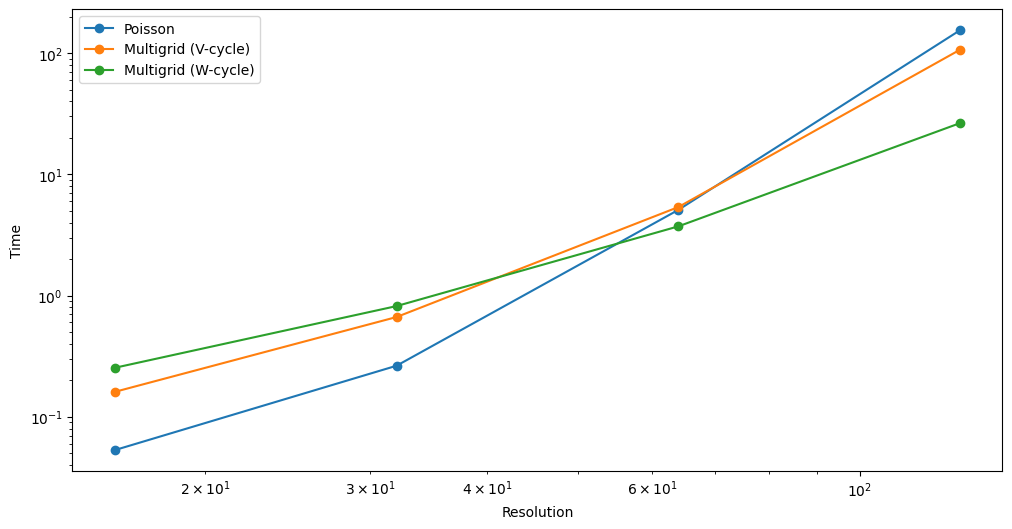

In [247]:
# Plotting the time versus resolution for the two solvers
plt.figure(figsize = (12, 6))
plt.loglog(N, time_P, 'o-', label = 'Poisson')
plt.loglog(N, time_M_Vcycle, 'o-', label = 'Multigrid (V-cycle)')
plt.loglog(N, time_M_Wcycle, 'o-', label = 'Multigrid (W-cycle)')
plt.xlabel('Resolution')
plt.ylabel('Time')
plt.legend()

<b>Comments on the plot</b>: As seen in the plot above, the Multigrid solver (V-cycle) becomes faster than the standard Jacobi solver at a resolution of $n \sim 64$. The W-cycle Multigrid solver also becomes faster than the Jacobi solver at this resolution and clearly performs better than the V-cycle for bigger resolutions. Another cycle to test could be the F-cycle.